# Load Data

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
import calendar
pd.set_option('display.max_columns', None)

In [2]:
sales_df = pd.read_csv('/Users/timlee/Desktop/ds021720/game-sales-FIDS/downloads/games_clean_df.csv')

In [3]:
sales_df.shape

(6242, 16)

In [4]:
print(sum(sales_df['Global_Sales'].notnull()))
print(sum(sales_df['NA_Sales'].notnull()))
print(sum(sales_df['PAL_Sales'].notnull()))
print(sum(sales_df['JP_Sales'].notnull()))
print(sum(sales_df['Other_Sales'].notnull()))

6242
5824
5699
1929
6141


In [ ]:
# PS - PS2 - PS3 - PS4
# XBOX - X360 - XONE
# N64 - GC - WII - WIIU - Switch
# GBA - DS - 3DS
# PSP - VITA
# Orphans: DC, PC

# Add Own Data and Shape Dates

In [5]:
consoles = {
    'N64': {'Family': 'Nintendo', 'Launch': 285, 'Successor': 'GC'},
    'GC': {'Family': 'Nintendo', 'Launch': 222, 'Successor': 'WII'},
    'WII': {'Family': 'Nintendo', 'Launch': 160, 'Successor': 'WIIU'},
    'WIIU': {'Family': 'Nintendo', 'Launch': 88, 'Successor': 'Switch'},
    'Switch': {'Family': 'Nintendo', 'Launch': 36, 'Successor': 'current'},
    'PS': {'Family': 'Sony', 'Launch': 303, 'Successor': 'PS2'},
    'PS2': {'Family': 'Sony', 'Launch': 240, 'Successor': 'PS3'},
    'PS3': {'Family': 'Sony', 'Launch': 160, 'Successor': 'PS4'},
    'PS4': {'Family': 'Sony', 'Launch': 77, 'Successor': 'PS5'},
    'PS5': {'Family': 'Sony', 'Launch': -7, 'Successor': 'current'},
    'XBOX': {'Family': 'Microsoft', 'Launch': 220, 'Successor': 'X360'},
    'X360': {'Family': 'Microsoft', 'Launch': 172, 'Successor': 'XONE'},
    'XONE': {'Family': 'Microsoft', 'Launch': 77, 'Successor': 'XBS'},
    'XBS': {'Family': 'Microsoft', 'Launch': -7, 'Successor': 'current'},
    'GBA': {'Family': 'Nintendo_Handheld', 'Launch': 228, 'Successor': 'DS'},
    'DS': {'Family': 'Nintendo_Handheld', 'Launch': 184, 'Successor': '3DS'},
    '3DS': {'Family': 'Nintendo_Handheld', 'Launch': 109, 'Successor': 'current'},
    'PSP': {'Family': 'Sony_Handheld', 'Launch': 183, 'Successor': 'VITA'},
    'VITA': {'Family': 'Sony_Handheld', 'Launch': 99, 'Successor': 'current'},
    'DC': {'Family': 'Sega', 'Launch': 256, 'Successor': 'current'},
    'PC': {'Family': 'PC', 'Launch': 0, 'Successor': 'current'},
}

In [11]:
# Modification for dates and building timeline of "months ago"

# new column for years ago
sales_df['years_ago'] = 2020 - sales_df['date'].str[-4:].astype(int)

# take first 3 characters of date for month abbreviation
sales_df['month_abbrev'] = sales_df['date'].str[:3]


def month_numerize(abbrev):
    for k, v in enumerate(calendar.month_abbr):
        if abbrev == v:
            return k
        
# column for numerical representations of month (Jan is 01, Feb is 02, etc.)
sales_df['month_num'] = sales_df['month_abbrev'].apply(month_numerize)

# months ago from April 2020
sales_df['months_ago'] = (sales_df['years_ago'] * 12) + (12 - sales_df['month_num']) + 4 - 12

# dummy categories for months, haven't put this into the dataframe yet
month_dummies = pd.get_dummies(sales_df['month_abbrev'], drop_first=True)

In [12]:
# return a percentage of when a game was released in a console's lifespan

# GTAV (PS3) was released right before the PS4 launched, so it has a 98% value
# God of War 2 (PS2) was released after the PS3 launched, so it has a value over 100%
# (game_release - console_launch) / (console_launch - successor_launch)
def generation_lifespan(console, months_ago):
    successor = consoles[console]['Successor']
    if successor == 'current':
        return successor
    else:
        successor_launch = consoles[successor]['Launch']
        console_launch = consoles[console]['Launch']
        return abs((months_ago - console_launch) / (console_launch - successor_launch))

In [13]:
# testing of generation_lifespan function
test_console = 'PS4'
test_months_ago = 65
generation_lifespan(test_console, test_months_ago)

0.14285714285714285

In [14]:
sales_df['generation_lifespan'] = sales_df.apply(lambda x: generation_lifespan(x['Platform'], x['months_ago']), axis=1)

In [18]:
sales_df.generation_lifespan.value_counts()

current                828
0.25                    63
0.4166666666666667      57
0.6875                  55
0.8125                  47
                      ... 
0.9066666666666666       1
0.43548387096774194      1
1.3125                   1
0.7710843373493976       1
1.0208333333333333       1
Name: generation_lifespan, Length: 681, dtype: int64

In [22]:
console_family = {
    'Nintendo' : ['N64', 'GC', 'WII', 'WIIU', 'Switch'],
    'Sony' : ['PS', 'PS2', 'PS3', 'PS4'],
    'Microsoft' : ['XBOX', 'X360', 'XONE'],
    'Nintendo_Handheld' : ['GBA', 'DS', '3DS'],
    'Sony_Handheld' : ['PSP', 'VITA'],
    'Sega' : ['DC'],
    'PC' : ['PC']
}

In [12]:
# PS - PS2 - PS3 - PS4
# XBOX - X360 - XONE
# N64 - GC - WII - WIIU - Switch
# GBA - DS - 3DS
# PSP - VITA
# Orphans: DC, PC
sales_df.Platform.value_counts()

PS2       1041
X360       753
PS3        653
XBOX       540
PC         490
PS4        400
WII        394
DS         388
PSP        343
GC         312
XONE       236
GBA        215
3DS        146
Switch      95
VITA        85
PS          78
WIIU        44
N64         17
DC          12
Name: Platform, dtype: int64

In [11]:
# we lack any sort of "epoch", or reference date to start counting months
# so we'll count backwards from April 1 2020

# "months ago" calculation performed at:
# https://www.timeanddate.com/date/durationresult.html
# set "State Date" to the Release date (game) or Launch date (console)
# set "End Date" to April 1 2020
# record ~months ago~, and discard any additional days

# Switch launch in March 2017, 36 months ago
# PS4 launch in November 2013, 77 months ago
# XONE launch in November 2013, 77 months ago
# Wii U launch in November 2012, 88 months ago
# VITA launch in December 2011, 99 months ago
# 3DS launch in February 2011, 109 months ago
# PS3 launch in November 2006, 160 months ago
# Wii launch in November 2006, 160 months ago
# X360 launch in November 2005, 172 months ago
# PSP launch in December 2004, 183 months ago
# NDS launch in November 2004, 184 months ago
# XBOX launch in November 2001, 220 months ago
# GC launch in September 2001, 222 months ago
# GBA launch in March 2001, 228 months ago
# PS2 launch in March 2000, 240 months ago
# DC launch in November 1998, 256 months ago
# N64 launch in June 1996, 285 months ago
# PS1 launch in December 1994, 303 months ago


In [21]:
#testing for months_ago
test_years_ago = 7
test_month = 9
(test_years_ago * 12) + (12 - test_month) + 4 - 12

79

In [19]:
sales_df.head()

,Rank,Name,Genre,ESRB_Rating,Platform,Publisher,Developer,Global_Sales,NA_Sales,PAL_Sales,JP_Sales,Other_Sales,Year,metascore,userscore,date,years_ago,month_abbrev,month_num,months_ago,generation_lifespan
0,20,Grand Theft Auto V,Action,M,PS3,Rockstar Games,Rockstar North,20.32,6.37,9.85,0.99,3.12,2013,97,8.3,"Sep 17, 2013",7,Sep,9,79,0.975904
1,21,Grand Theft Auto V,Action,M,PS4,Rockstar Games,Rockstar North,19.39,6.06,9.71,0.60,3.02,2014,97,8.3,"Nov 18, 2014",6,Nov,11,65,0.142857
2,31,Grand Theft Auto: Vice City,Action,M,PS2,Rockstar Games,Rockstar North,16.15,8.41,5.49,0.47,1.78,2002,95,8.8,"Oct 27, 2002",18,Oct,10,210,0.375
3,33,Grand Theft Auto V,Action,M,X360,Rockstar Games,Rockstar North,15.86,9.06,5.33,0.06,1.42,2013,97,8.3,"Sep 17, 2013",7,Sep,9,79,0.978947
4,41,Call of Duty: Modern Warfare 3,Shooter,M,X360,Activision,Infinity Ward,14.82,9.07,4.29,0.13,1.33,2011,88,3.4,"Nov 08, 2011",9,Nov,11,101,0.747368


# Pre-Regression Testing

In [15]:
sales_df.corr()

,Rank,Global_Sales,NA_Sales,PAL_Sales,JP_Sales,Other_Sales,Year,metascore,userscore,years_ago,month_num,months_ago
Rank,1.000000,-0.536982,-0.529525,-0.438955,-0.243043,-0.455438,0.000969,-0.326038,-0.132033,-0.000146,-0.093745,0.005411
Global_Sales,-0.536982,1.000000,0.916924,0.909778,0.236448,0.892993,0.063246,0.308538,0.043450,-0.063361,0.110411,-0.070216
NA_Sales,-0.529525,0.916924,1.000000,0.690198,0.097025,0.733107,0.022769,0.322977,0.058544,-0.022727,0.117445,-0.029821
PAL_Sales,-0.438955,0.909778,0.690198,1.000000,0.178308,0.844323,0.135632,0.258746,-0.001762,-0.135410,0.097777,-0.142046
JP_Sales,-0.243043,0.236448,0.097025,0.178308,1.000000,0.237573,-0.117656,0.142650,0.162321,0.116294,-0.044779,0.119626
Other_Sales,-0.455438,0.892993,0.733107,0.844323,0.237573,1.000000,0.101043,0.262991,0.025308,-0.101095,0.094615,-0.107205
Year,0.000969,0.063246,0.022769,0.135632,-0.117656,0.101043,1.000000,0.030256,-0.231815,-0.997386,-0.110172,-0.995702
metascore,-0.326038,0.308538,0.322977,0.258746,0.142650,0.262991,0.030256,1.000000,0.543455,-0.030125,0.015188,-0.031172
userscore,-0.132033,0.043450,0.058544,-0.001762,0.162321,0.025308,-0.231815,0.543455,1.000000,0.235872,-0.017210,0.238039
years_ago,-0.000146,-0.063361,-0.022727,-0.135410,0.116294,-0.101095,-0.997386,-0.030125,0.235872,1.000000,0.111283,0.998263


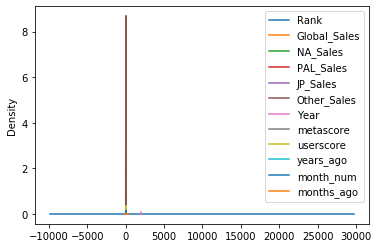

In [16]:
sales_df.plot.kde()

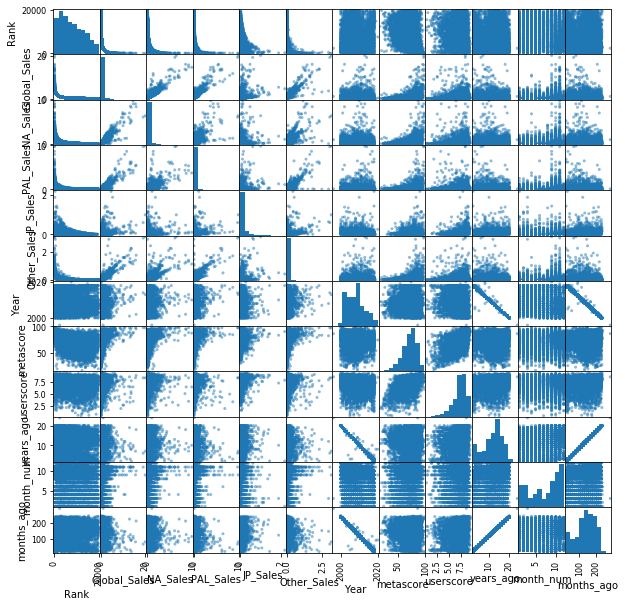

In [17]:
pd.plotting.scatter_matrix(sales_df, figsize = [10, 10]);
plt.show()